Bu notebook RNN ailesinden olan GRU ve LSTM model yapılarının gösterim demosu olması amacıyla oluşturulmuştur. Notebook'u, anlaşılması ve değiştirilmesi kolay olması adına NN projelerinin ana alt başlıklarına -PHASE ile gösterilen- böldüm. Kimi ana alt başlıkların içinde başka alt başlıklar da var. 
Bu notebook'un "RNN Models - Prototype" ile olan ana farkı birden fazla elemanı olan sekansları -tarihsel veri noktası toplulukları- kullanmasıdır.
Çoğu üst başlık ve içlerindeki alt başlıklar için olan açıklamalar diğer Makine Öğrenimi modellerinin olduğu notebook'lar için de aynıdır, bu yüzden onlarda fazladan açıklamaya rastlamayabilirsiniz. 

# Setup

In [ ]:
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm 

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.dates as mdates

In [2]:
data_seed = 12 # Elde edilen sonuçların tekrarı için rastgelelik kısıtlayıcı bir parametre

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# PHASE 1: Load Data 

In [5]:
""" EDA 3'ten gelen veri """

df = pd.read_csv(r"DATASETS\ForForecast.csv")
df['TransactionDateTime'] = pd.to_datetime(df['TransactionDateTime'])
df.set_index('TransactionDateTime', inplace=True)
df = df.sort_index()

print(f"Shape {df.shape}")
df.tail(10)

Shape (13499, 19)


ChannelKey  DataAreaKey InventKey InventLocationKey  \
TransactionDateTime                                                        
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   

                    CampaignKrcKey  SalesQuantity  SalesGrossAmount  \
TransactionDateTime                                                   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.51   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.52   
2024-02-08 22:12:00           6414            1.0            115.91   
2024-02-08 22:28:00            -99            1.0            110.49   
2024-02-08 22:28:00           6415            3.0            101.99   
2024-02-08 22:28:00              2            1.0            297.49   
2024-02-08 22:28:00            -99            1.0             84.99   
2024-02-08 22:28:00            -99            2.0            305.99   

                     Return_Quantity  NetQuantity  NetGrossAmount  \
TransactionDateTime                                                 
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.51   
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.52   
2024-02-08 22:12:00              0.0          1.0          115.91   
2024-02-08 22:28:00              0.0          1.0          110.49   
2024-02-08 22:28:00              0.0          3.0          101.99   
2024-02-08 22:28:00              0.0          1.0          297.49   
2024-02-08 22:28:00              0.0          1.0           84.99   
2024-02-08 22:28:00              0.0          2.0          305.99   

                     ReturnGrossAmount  ReturnNetAmount  NetAmountWOVat  \
TransactionDateTime                                                       
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.26   
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.27   
2024-02-08 22:12:00                0.0              0.0           96.59   
2024-02-08 22:28:00                0.0              0.0           92.07   
2024-02-08 22:28:00                0.0              0.0           84.99   
2024-02-08 22:28:00                0.0              0.0          270.45   
2024-02-08 22:28:00                0.0              0.0           70.83   
2024-02-08 22:28:00                0.0              0.0          254.99   

                     DiscountAmount  DiscountGrossAmount RboStoreKey  \
TransactionDateTime                                                    
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.07               343.07      others   
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.06               343.06      others   
2024-02-08 22:12:00          213.49               213.49      others   
2024-02-08 22:28:00  

In [6]:
df.dtypes

ChannelKey               int64
DataAreaKey              int64
InventKey               object
InventLocationKey       object
CampaignKrcKey          object
SalesQuantity          float64
SalesGrossAmount       float64
Return_Quantity        float64
NetQuantity            float64
NetGrossAmount         float64
ReturnGrossAmount      float64
ReturnNetAmount        float64
NetAmountWOVat         float64
DiscountAmount         float64
DiscountGrossAmount    float64
RboStoreKey             object
NetAmount              float64
HourIntervalKey          int64
IsFirstOrder              bool
dtype: object

# PHASE 2: Prepare Data

## Resample and fix

In [7]:
desired_column = 'NetAmountWOVat' # Modelin ana odak noktası burada tanımlanır, başka hedefler isterseniz değiştiriniz.

In [8]:
df = df[[desired_column]]

In [9]:
""" 
Zaman serilerini modellere uygun yapabilmek için her zaman noktasının eşsiz olması gerekir -örneğin 2024-01-31 09:00:00 birden fazla olamaz-,
ana veride bu durum böyle değildi, bu yüzden df.resample() kullanılarak zaman noktalarını eşşiz hale getirmek gerekiyor. Aynı noktadaki verileri,
elinizdeki hedefin doğasını uygun olarak toplayabilir ya da ortalamasını alabilirsiniz. Bu demo notebook'u için elimde az miktarda veri vardı, bu yüzden
verileri saatlik olarak kümelendirdim. Hedef net satış rakamları ile alakalı olduğundan da toplamayı seçtim. 
"""

resampled_df = df.resample('60T', closed="left").sum() # 60T kısmı bir saat anlamına gelir, farklı zaman aralıklarına sıkıştırmak için o kısmı değiştirebilirsiniz
resampled_df.shape

(206, 1)

In [10]:
resampled_df.head(10)

NetAmountWOVat
TransactionDateTime                
2024-01-31 09:00:00         7444.94
2024-01-31 10:00:00        16321.85
2024-01-31 11:00:00        16112.86
2024-01-31 12:00:00         9955.61
2024-01-31 13:00:00        36883.48
2024-01-31 14:00:00        11374.87
2024-01-31 15:00:00        49252.87
2024-01-31 16:00:00        65630.39
2024-01-31 17:00:00        31425.66
2024-01-31 18:00:00        39486.80

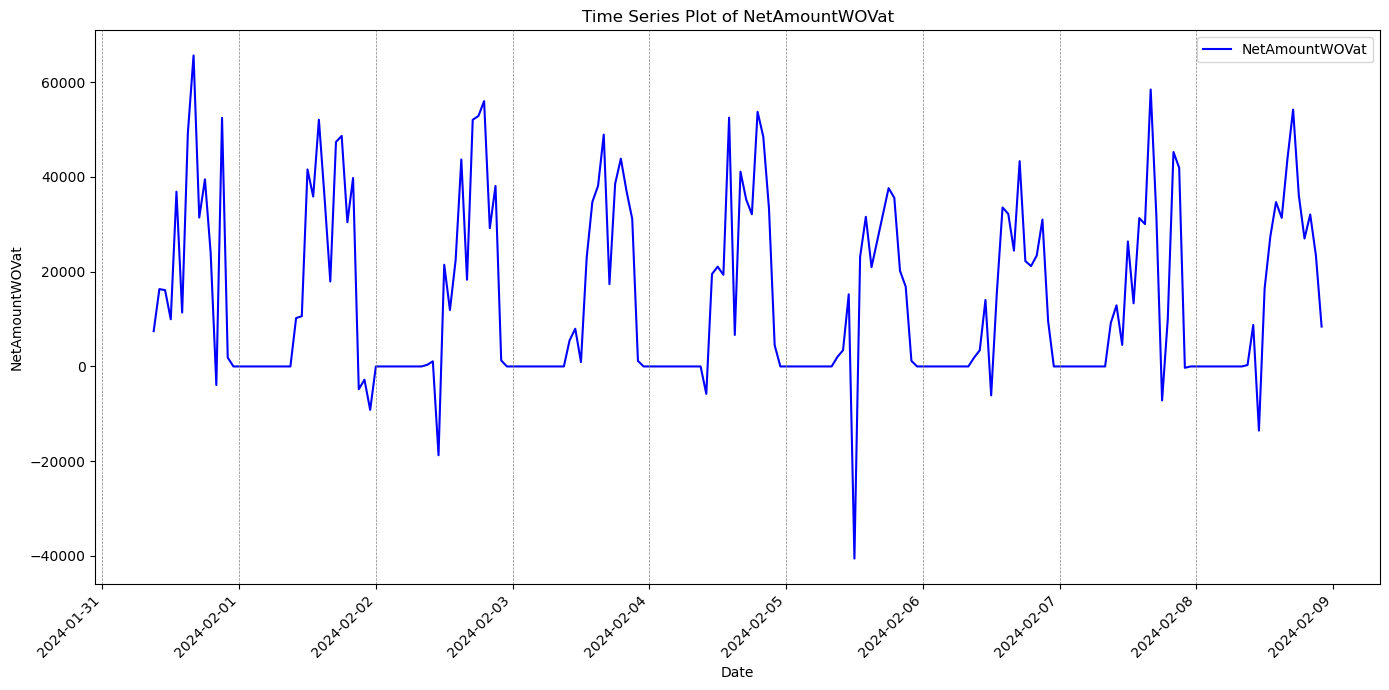

In [11]:
""" Verinin dağılımını gösteren bir grafik"""

plt.figure(figsize=(14, 7))

plt.plot(resampled_df.index, resampled_df[f'{desired_column}'], label=f'{desired_column}', color='blue')

## Grafiği özelleştirmek için olan bölüm
plt.xlabel('Date')
plt.ylabel(f'{desired_column}')
plt.title(f'Time Series Plot of {desired_column}')

# Tarih formatı
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Veri sıklığına göre ayarlayınız
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Tarih formatına göre ayarlayınız

plt.xticks(rotation=45, ha='right')
for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout() 
plt.show()

In [12]:
""" Verinin genelini temsil etmeyen ve modeli kötü etkileyebilecek uç noktaların ayıklanması için bir bölüm """

Q1 = resampled_df[desired_column].quantile(0.25)
Q3 = resampled_df[desired_column].quantile(0.75)
IQR = Q3 - Q1

# Uç noktalar için sınır tanımlayınız
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1 * IQR

outliers = resampled_df[(resampled_df[desired_column] < lower_bound) | (resampled_df[desired_column] > upper_bound)]

resampled_df = resampled_df[(resampled_df[desired_column] >= lower_bound) & (resampled_df[desired_column] <= upper_bound)]

# Uç nokta istatistiği
print("Number of outliers removed:", len(outliers))
print("DataFrame size after removing outliers:", len(resampled_df))

Number of outliers removed: 2
DataFrame size after removing outliers: 204


In [13]:
""" 
Modelin tahmin yapmak için kullacağı değişkenlerin tanımlandığı bölüm. Bu bir öngörü modeli olacağı için, en sağlıklısı önceden görmesi kesin
ya da kesine yakın değişkenlerin kullanılması olur -hangi saat ya da hangi gün olacağı gibi-.
"""

resampled_df["HourInterval"] = resampled_df.index.hour # Saat aralığı
resampled_df['DayOfWeek'] = resampled_df.index.dayofweek + 1 # Haftanın hangi günü olduğu

resampled_df[f'{desired_column} Before'] = resampled_df[f'{desired_column}'].shift(1) # Bir önceki satış miktarı

resampled_df = resampled_df.dropna()

In [14]:
print(resampled_df.shape)
resampled_df.head()

(203, 4)


NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-01-31 10:00:00        16321.85            10          3   
2024-01-31 11:00:00        16112.86            11          3   
2024-01-31 12:00:00         9955.61            12          3   
2024-01-31 13:00:00        36883.48            13          3   
2024-01-31 14:00:00        11374.87            14          3   

                     NetAmountWOVat Before  
TransactionDateTime                         
2024-01-31 10:00:00                7444.94  
2024-01-31 11:00:00               16321.85  
2024-01-31 12:00:00               16112.86  
2024-01-31 13:00:00                9955.61  
2024-01-31 14:00:00               36883.48

In [15]:
""" 
Burada sekans uzunluğu ve değişkenlerin listesi tanımlı. Daha kapsamlı bir geçmişi inceleyerek karar veren modeller için bu uzunluğu arttırabilirsiniz.
"""
sequence_length = 3
features = ['HourInterval', 'DayOfWeek', f'{desired_column} Before']

## Train-Test Split

In [16]:
"""
Eğitme ve değerlendirme veri setlerinin tanımlandığı bölüm. Literatürde küçük veri setlerinin 80'e 20 bölünmesi tavsiye edilir. Daha büyük
veri setleri kullanıyorsanız bu oranı değiştirebilirsiniz.
"""

train_ratio = 0.8  # Oranı isteğiniz şekilde değiştirin
train_size = int(len(resampled_df) * train_ratio)

train_df = resampled_df[:train_size]
valid_df = resampled_df[train_size:]

In [17]:
print("Train size:", train_size, "Valid Size:", len(resampled_df) - train_size)

Train size: 162 Valid Size: 41


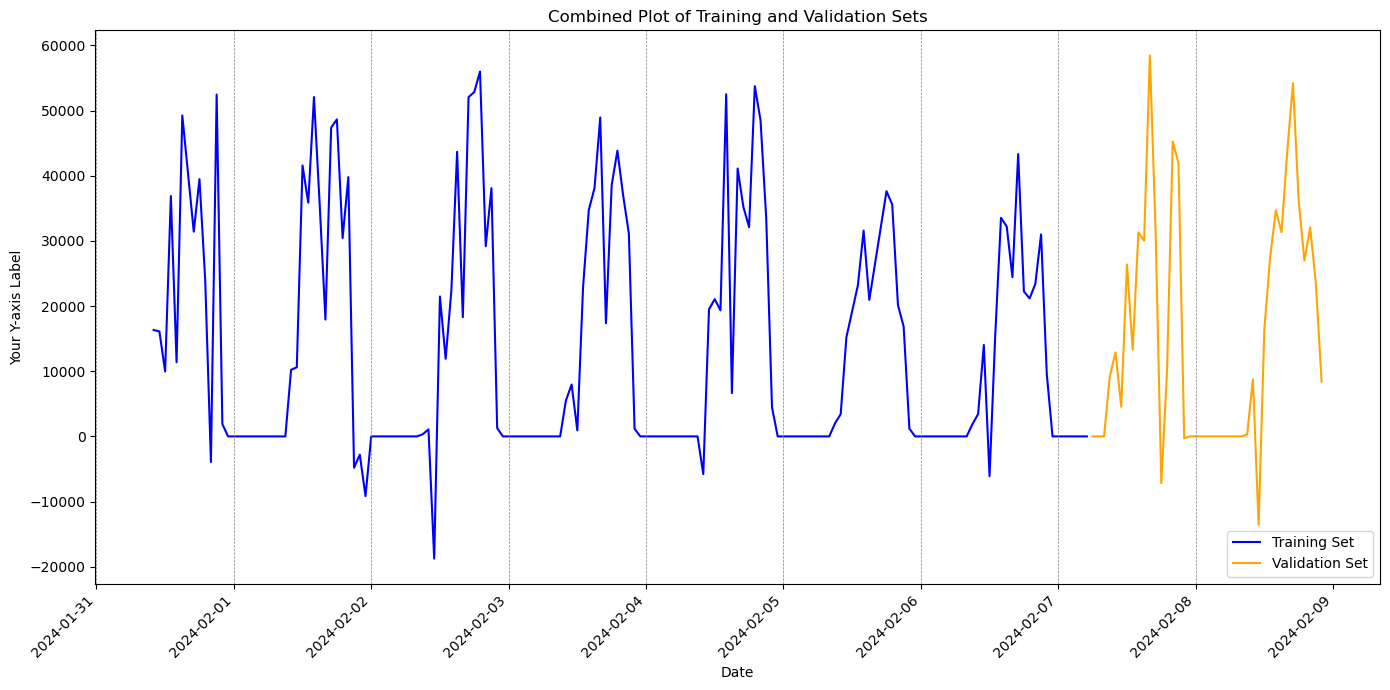

In [18]:
""" Eğitim ve değerlendirme setlerinin ayrımını gösteren grafik """
plt.figure(figsize=(14, 7))

plt.plot(train_df.index, train_df[f'{desired_column}'], label='Training Set', color='blue')
plt.plot(valid_df.index, valid_df[f'{desired_column}'], label='Validation Set', color='orange')

## Grafiği özelleştirmek için olan bölüm
plt.xlabel('Date')
plt.ylabel('Your Y-axis Label')
plt.title('Combined Plot of Training and Validation Sets')

# Tarih formatı
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Veri sıklığına göre ayarlayınız
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Tarih formatına göre ayarlayınız

plt.xticks(rotation=45, ha='right')
for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout() 
plt.show()

## Normalization

In [19]:
""" 
NN modellerinde değişkenlerin değerlerini standartlaştırmak modele olumlu etki yapar, çünkü böylece daha büyük sayılara sahip değişkenler
modelde hakimiyet kuramaz ve değişkenlerin tahmin için önemi daha sağlıklı gösterilmiş olur.
"""

train_original = train_df.copy()
valid_original = valid_df.copy()
train_original_stats = train_original.describe().to_dict() # Uygulama geliştirmek için kullanılacağı zaman gerekli normalizasyon istatistikleri

train_original.describe()

NetAmountWOVat  HourInterval   DayOfWeek  NetAmountWOVat Before
count      162.000000    162.000000  162.000000             162.000000
mean     13545.942778     11.567901    4.049383           13591.899198
std      17835.364789      7.031320    2.021015           17809.817537
min     -18747.920000      0.000000    1.000000          -18747.920000
25%          0.000000      5.000000    2.000000               0.000000
50%       1226.130000     12.000000    4.000000            1561.635000
75%      28517.032500     18.000000    6.000000           28517.032500
max      55993.660000     23.000000    7.000000           55993.660000

In [20]:
""" Normalizasyon istatistikleri uygulama için kullanılmak üzere kaydedilir """

with open("normalization_stats.json", "w") as json_file:
    json.dump(train_original.NetAmountWOVat.describe().to_dict(), json_file)

In [21]:
""" Z-score normalizasyonu """

for column in train_df:
    if column in ['HourInterval', 'DayOfWeek']:
        continue
        
    train_df[column] = (train_df[column] - train_original[f'{desired_column}'].mean()) / train_original[f'{desired_column}'].std()
    
for column in valid_df:
    if column in ['HourInterval', 'DayOfWeek']:
        continue

    valid_df[column] = (valid_df[column] - train_original[f'{desired_column}'].mean()) / train_original[f'{desired_column}'].std()

In [22]:
train_df.describe()

NetAmountWOVat  HourInterval   DayOfWeek  NetAmountWOVat Before
count    1.620000e+02    162.000000  162.000000             162.000000
mean    -2.741291e-17     11.567901    4.049383               0.002577
std      1.000000e+00      7.031320    2.021015               0.998568
min     -1.810665e+00      0.000000    1.000000              -1.810665
25%     -7.594991e-01      5.000000    2.000000              -0.759499
50%     -6.907519e-01     12.000000    4.000000              -0.671941
75%      8.394047e-01     18.000000    6.000000               0.839405
max      2.379975e+00     23.000000    7.000000               2.379975

In [23]:
valid_df.describe()

NetAmountWOVat  HourInterval  DayOfWeek  NetAmountWOVat Before
count       41.000000     41.000000  41.000000              41.000000
mean         0.112993     12.536585   3.560976               0.101487
std          1.029418      6.364344   0.502433               1.036621
min         -1.518725      0.000000   3.000000              -1.518725
25%         -0.759499      8.000000   3.000000              -0.759499
50%         -0.244404     13.000000   4.000000              -0.244404
75%          0.996013     18.000000   4.000000               0.996013
max          2.518003     23.000000   4.000000               2.518003

In [24]:
train_df.head(sequence_length + 1)

NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-01-31 10:00:00        0.155641            10          3   
2024-01-31 11:00:00        0.143923            11          3   
2024-01-31 12:00:00       -0.201304            12          3   
2024-01-31 13:00:00        1.308498            13          3   

                     NetAmountWOVat Before  
TransactionDateTime                         
2024-01-31 10:00:00              -0.342073  
2024-01-31 11:00:00               0.155641  
2024-01-31 12:00:00               0.143923  
2024-01-31 13:00:00              -0.201304

In [25]:
train_df.tail(sequence_length + 1)

NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-02-07 02:00:00       -0.759499             2          3   
2024-02-07 03:00:00       -0.759499             3          3   
2024-02-07 04:00:00       -0.759499             4          3   
2024-02-07 05:00:00       -0.759499             5          3   

                     NetAmountWOVat Before  
TransactionDateTime                         
2024-02-07 02:00:00              -0.759499  
2024-02-07 03:00:00              -0.759499  
2024-02-07 04:00:00              -0.759499  
2024-02-07 05:00:00              -0.759499

## Make Sequences

Bu bölümde veriyi PyTorch kütüphanesine uygun olacak şekilde dönüştürmek için gerekli kodlar bulunmaktadır

In [26]:
def create_sequences(data, sequence_length, label_column=f'{desired_column}'):
    padded_data = pd.concat([data.iloc[:1]] * (sequence_length - 1) + [data], ignore_index=True)
    
    X_sequences = []
    y_targets = []
    for i in range(len(padded_data) - sequence_length + 1):
        seq = padded_data.iloc[i:i+sequence_length]
        target = seq.iloc[-1][label_column]
        X_sequences.append(torch.tensor(seq[features].values, dtype=torch.float32))
        y_targets.append(torch.tensor(target, dtype=torch.float32))
    
    return X_sequences, y_targets

In [27]:
X_train, y_train = create_sequences(train_df, sequence_length)
X_valid, y_valid = create_sequences(valid_df, sequence_length)

In [28]:
for i in range(len(train_df) - 1):
    print(X_train[i], y_train[i], X_train[i].shape)

tensor([[10.0000,  3.0000, -0.3421],
        [10.0000,  3.0000, -0.3421],
        [10.0000,  3.0000, -0.3421]]) tensor(0.1556) torch.Size([3, 3])
tensor([[10.0000,  3.0000, -0.3421],
        [10.0000,  3.0000, -0.3421],
        [11.0000,  3.0000,  0.1556]]) tensor(0.1439) torch.Size([3, 3])
tensor([[10.0000,  3.0000, -0.3421],
        [11.0000,  3.0000,  0.1556],
        [12.0000,  3.0000,  0.1439]]) tensor(-0.2013) torch.Size([3, 3])
tensor([[11.0000,  3.0000,  0.1556],
        [12.0000,  3.0000,  0.1439],
        [13.0000,  3.0000, -0.2013]]) tensor(1.3085) torch.Size([3, 3])
tensor([[12.0000,  3.0000,  0.1439],
        [13.0000,  3.0000, -0.2013],
        [14.0000,  3.0000,  1.3085]]) tensor(-0.1217) torch.Size([3, 3])
tensor([[13.0000,  3.0000, -0.2013],
        [14.0000,  3.0000,  1.3085],
        [15.0000,  3.0000, -0.1217]]) tensor(2.0020) torch.Size([3, 3])
tensor([[14.0000,  3.0000,  1.3085],
        [15.0000,  3.0000, -0.1217],
        [17.0000,  3.0000,  2.0020]]) tensor(1.0

In [29]:
for i in range(len(valid_df) - 1):
    print(X_valid[i], y_valid[i], X_valid[i].shape)

tensor([[ 6.0000,  3.0000, -0.7595],
        [ 6.0000,  3.0000, -0.7595],
        [ 6.0000,  3.0000, -0.7595]]) tensor(-0.7595) torch.Size([3, 3])
tensor([[ 6.0000,  3.0000, -0.7595],
        [ 6.0000,  3.0000, -0.7595],
        [ 7.0000,  3.0000, -0.7595]]) tensor(-0.7595) torch.Size([3, 3])
tensor([[ 6.0000,  3.0000, -0.7595],
        [ 7.0000,  3.0000, -0.7595],
        [ 8.0000,  3.0000, -0.7595]]) tensor(-0.7595) torch.Size([3, 3])
tensor([[ 7.0000,  3.0000, -0.7595],
        [ 8.0000,  3.0000, -0.7595],
        [ 9.0000,  3.0000, -0.7595]]) tensor(-0.2444) torch.Size([3, 3])
tensor([[ 8.0000,  3.0000, -0.7595],
        [ 9.0000,  3.0000, -0.7595],
        [10.0000,  3.0000, -0.2444]]) tensor(-0.0362) torch.Size([3, 3])
tensor([[ 9.0000,  3.0000, -0.7595],
        [10.0000,  3.0000, -0.2444],
        [11.0000,  3.0000, -0.0362]]) tensor(-0.5046) torch.Size([3, 3])
tensor([[10.0000,  3.0000, -0.2444],
        [11.0000,  3.0000, -0.0362],
        [12.0000,  3.0000, -0.5046]]) tensor

In [30]:
X_train_tensor = torch.stack(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_valid_tensor = torch.stack(X_valid)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

batch_size = 8 # Modelin eğitilme hızına etki eden bir parametre, küçük olması modeli hızlandırır ama nüansları anlamasını zorlaştırabilir.

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [31]:
for inputs_train, targets_train in train_loader:
    print(inputs_train.shape, targets_train.shape)
    print(inputs_train, targets_train)
    break

torch.Size([8, 3, 3]) torch.Size([8])
tensor([[[10.0000,  3.0000, -0.3421],
         [10.0000,  3.0000, -0.3421],
         [10.0000,  3.0000, -0.3421]],

        [[10.0000,  3.0000, -0.3421],
         [10.0000,  3.0000, -0.3421],
         [11.0000,  3.0000,  0.1556]],

        [[10.0000,  3.0000, -0.3421],
         [11.0000,  3.0000,  0.1556],
         [12.0000,  3.0000,  0.1439]],

        [[11.0000,  3.0000,  0.1556],
         [12.0000,  3.0000,  0.1439],
         [13.0000,  3.0000, -0.2013]],

        [[12.0000,  3.0000,  0.1439],
         [13.0000,  3.0000, -0.2013],
         [14.0000,  3.0000,  1.3085]],

        [[13.0000,  3.0000, -0.2013],
         [14.0000,  3.0000,  1.3085],
         [15.0000,  3.0000, -0.1217]],

        [[14.0000,  3.0000,  1.3085],
         [15.0000,  3.0000, -0.1217],
         [17.0000,  3.0000,  2.0020]],

        [[15.0000,  3.0000, -0.1217],
         [17.0000,  3.0000,  2.0020],
         [18.0000,  3.0000,  1.0025]]]) tensor([ 0.1556,  0.1439, -0.2013,

# PHASE 3: Training

## Model Classes

Eğitilecek modellerin ve özel hata fonksiyonunun tanımlandığı bölüm. Modellerin normal halleri ve çift taraflı halleri tanımlı. Genelde çift taraflı versiyonlar bu tip sezonsal etki gösteren durumlarda daha yüksek performans verir, o yüzden ilerideki bölümlerde ben o versiyonlarını kullandım.
GRU ve LSTM yapıları arasındaki temel fark; GRU mimarisinin daha kısa zamanlı ve odaklı, LSTM mimarisinin ise daha uzun zamanlı ve genellemeci bir yapısı olmasıdır.

In [32]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(BiGRUModel, self).__init__()
        self.bi_gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        out, _ = self.bi_gru(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        
        return out


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BiLSTMModel, self).__init__()
        self.bi_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        out, _ = self.bi_lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [33]:
"""
Mean squared error ve Huber error kullanılarak oluşturulmuş bir özel kayıp fonksiyonu
"""

class CustomLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        self.huber_loss = nn.SmoothL1Loss()

    def forward(self, predicted, target):
        mse_loss = self.mse_loss(predicted, target)
        huber_loss = self.huber_loss(predicted, target)
        custom_loss = (1 - self.alpha) * mse_loss + self.alpha * huber_loss

        return custom_loss

## Train-Test Classes

In [34]:
"""
Modeli eğitmek için kullanılacak fonksiyonun tanımı. Modelin parametrelerini kaydetmek veya onu belli bir performansa ulaştıktan sonra durdurmak 
-early stopping- için bölümler mevcut. hedefiniz doğrultusunda ayarlayabilirsiniz. Ben ileriki bölümlerde parametreleri kaydetme yolunu kullandım. 
Daha büyük modelleri daha uzun epoch'lar boyunca eğitmek isterseniz bu yol çok maliyetli bir hal alacaktır, o yüzden bu durumda "early stopping"
kullanmak daha uygun olur.
"""

def train_n_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs, early_stopping=False, model_save_path=None):
    stats_dict = {'Epoch': [], 'Train Loss': [], 'Train RMSE': [], 'Valid Loss': [], 'Valid RMSE': []}

    if early_stopping:
        best_valid_loss = float('inf')
        consecutive_no_improvement = 0
        patience = 50
    
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        total_loss_train = 0.0
        total_samples_train = 0

        for inputs_train, targets_train in train_loader:
            optimizer.zero_grad()
            inputs_train = torch.tensor(inputs_train, dtype=torch.float32)
            targets_train = torch.tensor(targets_train, dtype=torch.float32).view(-1, 1)
            outputs_train = model(inputs_train)
            loss_train = criterion(outputs_train, targets_train)
            loss_train.backward()
            optimizer.step()

            total_loss_train += loss_train.item()
            total_samples_train += targets_train.size(0)

        # Doğrulama seti
        model.eval()
        total_loss_valid = 0.0
        total_samples_valid = 0

        with torch.no_grad():
            for inputs_valid, targets_valid in valid_loader:
                inputs_valid = torch.tensor(inputs_valid, dtype=torch.float32)
                targets_valid = torch.tensor(targets_valid, dtype=torch.float32).view(-1, 1)
                outputs_valid = model(inputs_valid)
                loss_valid = criterion(outputs_valid, targets_valid)

                total_loss_valid += loss_valid.item()
                total_samples_valid += targets_valid.size(0)

        mean_loss_train = total_loss_train / len(train_loader)
        rmse_train = np.sqrt(mean_loss_train)

        mean_loss_valid = total_loss_valid / len(valid_loader)
        rmse_valid = np.sqrt(mean_loss_valid)

        step = max(1, num_epochs // 10)
        if epoch % step == 0:
            print("Epoch %d: Train Loss %.4f, Train RMSE %.4f | Valid Loss %.4f, Valid RMSE %.4f"
                    % (epoch, mean_loss_train, rmse_train, mean_loss_valid, rmse_valid))
            
        # Kaydedilecek yol sağlandıysa kaydet
        if model_save_path:
            epoch_model_save_path = f"{model_save_path}\model_epoch_{epoch}.pth"
            torch.save(model.state_dict(), epoch_model_save_path)
    
        # İstatistikleri sözlüğe kaydet
        stats_dict['Epoch'].append(epoch)
        stats_dict['Train Loss'].append(mean_loss_train)
        stats_dict['Train RMSE'].append(rmse_train)
        stats_dict['Valid Loss'].append(mean_loss_valid)
        stats_dict['Valid RMSE'].append(rmse_valid)

        if early_stopping:
            if mean_loss_valid < best_valid_loss:
                best_valid_loss = mean_loss_valid
                consecutive_no_improvement = 0
            else:
                consecutive_no_improvement += 1
    
            if consecutive_no_improvement >= patience:
                print(f"Early stopping: No improvement for {patience} consecutive epochs.")
                break

    # Sözlüğü DataFrame'e çevir
    stats_df = pd.DataFrame(stats_dict)
    
    return stats_df

## Main training phase

### GRU

Epochs:   0%|▏                                                                         | 1/501 [00:06<51:56,  6.23s/it]

Epoch 0: Train Loss 0.3835, Train RMSE 0.6193 | Valid Loss 0.3369, Valid RMSE 0.5804


Epochs:  10%|███████▍                                                                 | 51/501 [01:41<06:52,  1.09it/s]

Epoch 50: Train Loss 0.1096, Train RMSE 0.3311 | Valid Loss 0.2144, Valid RMSE 0.4631


Epochs:  20%|██████████████▌                                                         | 101/501 [02:22<05:14,  1.27it/s]

Epoch 100: Train Loss 0.0770, Train RMSE 0.2775 | Valid Loss 0.2371, Valid RMSE 0.4869


Epochs:  30%|█████████████████████▋                                                  | 151/501 [02:56<03:38,  1.60it/s]

Epoch 150: Train Loss 0.0595, Train RMSE 0.2439 | Valid Loss 0.2585, Valid RMSE 0.5084


Epochs:  40%|████████████████████████████▉                                           | 201/501 [03:25<02:56,  1.70it/s]

Epoch 200: Train Loss 0.0166, Train RMSE 0.1288 | Valid Loss 0.3146, Valid RMSE 0.5609


Epochs:  50%|████████████████████████████████████                                    | 251/501 [03:55<02:18,  1.80it/s]

Epoch 250: Train Loss 0.0043, Train RMSE 0.0659 | Valid Loss 0.3226, Valid RMSE 0.5679


Epochs:  60%|███████████████████████████████████████████▎                            | 301/501 [04:24<01:48,  1.84it/s]

Epoch 300: Train Loss 0.0559, Train RMSE 0.2364 | Valid Loss 0.3480, Valid RMSE 0.5899


Epochs:  70%|██████████████████████████████████████████████████▍                     | 351/501 [04:51<01:09,  2.17it/s]

Epoch 350: Train Loss 0.0012, Train RMSE 0.0346 | Valid Loss 0.3244, Valid RMSE 0.5696


Epochs:  80%|█████████████████████████████████████████████████████████▋              | 401/501 [05:43<00:51,  1.94it/s]

Epoch 400: Train Loss 0.0049, Train RMSE 0.0697 | Valid Loss 0.3498, Valid RMSE 0.5914


Epochs:  90%|████████████████████████████████████████████████████████████████▊       | 451/501 [06:07<00:22,  2.26it/s]

Epoch 450: Train Loss 0.0040, Train RMSE 0.0633 | Valid Loss 0.3500, Valid RMSE 0.5916


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 501/501 [06:27<00:00,  1.29it/s]

Epoch 500: Train Loss 0.0000, Train RMSE 0.0025 | Valid Loss 0.3471, Valid RMSE 0.5891
Best Epoch (Validation Loss): 65, Value: 0.20047893204598954
Best Epoch (Validation RMSE): 65, Value: 0.4477487376263495


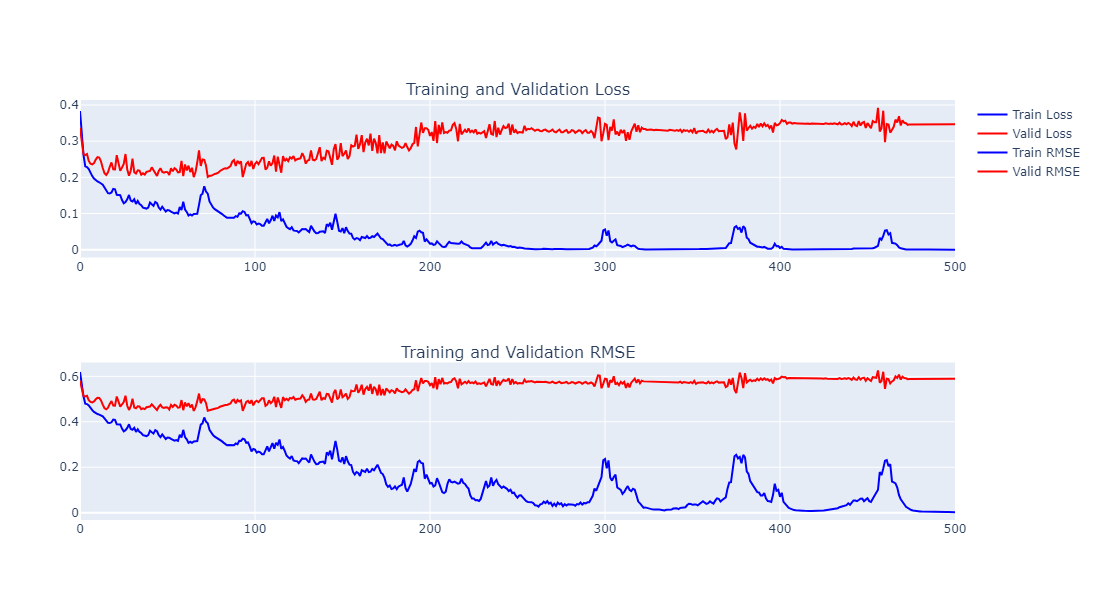

In [35]:
## Modelin argümanlarına karar verildiği kısım
GRU_input_size = len(features)
GRU_hidden_size = 128
GRU_output_size = 1
GRU_num_layers = 2

GRU_learning_rate = 0.001
GRU_weight_decay = 0.0001
GRU_dropout = 0

## Modelin performansını tekrar edebilmek adına rastgeleliği engellemek için olan kısım
GRU_seed = 169
torch.manual_seed(GRU_seed)

## Modelin, kayıp fonksiyonunun ve optimizasyon algoritmasının tanımlandığı bölüm
GRU_model = BiGRUModel(input_size=GRU_input_size, hidden_size=GRU_hidden_size, output_size=GRU_output_size, num_layers=GRU_num_layers, dropout=GRU_dropout)
GRU_criterion = CustomLoss(alpha=1) # alpha 1 huber loss, alpha 0 mse loss
GRU_optimizer = optim.AdamW(GRU_model.parameters(), lr=GRU_learning_rate, weight_decay=GRU_weight_decay)

GRU_n_epochs = 500
GRU_stats_df = train_n_validate(train_loader, valid_loader, GRU_model, GRU_optimizer, GRU_criterion, GRU_n_epochs + 1,
            early_stopping=False, model_save_path=r"saved_GRU")

## Modelin kaydedilmiş parametreleri arasından en iyisinin performansını göstermek için olan kısım
best_loss_index = int(GRU_stats_df.loc[GRU_stats_df['Valid Loss'].idxmin()]['Epoch'])
best_epoch_loss = GRU_stats_df.loc[best_loss_index]['Valid Loss']
best_rmse_index = int(GRU_stats_df.loc[GRU_stats_df['Valid RMSE'].idxmin()]['Epoch'])
best_epoch_rmse = GRU_stats_df.loc[best_rmse_index]['Valid RMSE']

print(f"Best Epoch (Validation Loss): {best_loss_index}, Value: {best_epoch_loss}")
print(f"Best Epoch (Validation RMSE): {best_rmse_index}, Value: {best_epoch_rmse}")

fig = make_subplots(rows=2, cols=1, subplot_titles=['Training and Validation Loss', 'Training and Validation RMSE'])

fig.add_trace(go.Scatter(x=GRU_stats_df['Epoch'], y=GRU_stats_df['Train Loss'], mode='lines', name='Train Loss', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=GRU_stats_df['Epoch'], y=GRU_stats_df['Valid Loss'], mode='lines', name='Valid Loss', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=GRU_stats_df['Epoch'], y=GRU_stats_df['Train RMSE'], mode='lines', name='Train RMSE', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=GRU_stats_df['Epoch'], y=GRU_stats_df['Valid RMSE'], mode='lines', name='Valid RMSE', line=dict(color='red')), row=2, col=1)

fig.update_layout(
    height=600,
    showlegend=True,
)

# Show the figure
fig.show()

In [36]:
## Kaydedilen modeller arasından en iyisinin seçildiği bölüm
print("Best epoch was:", best_loss_index)
path = fr"saved_GRU\model_epoch_{best_loss_index}.pth"
GRU_model.load_state_dict(torch.load(path))

Best epoch was: 65


<All keys matched successfully>

In [37]:
## Modelin daha sonra uygulama içinde kullanılması için kaydedildiği kısım
torch.save(GRU_model, fr"MODELS\main_GRU_model.pth")

### LSTM

Epochs:   0%|▏                                                                         | 1/500 [00:01<14:13,  1.71s/it]

Epoch 0: Train Loss 0.5435, Train RMSE 0.7372 | Valid Loss 0.4964, Valid RMSE 0.7045


Epochs:  10%|███████▍                                                                 | 51/500 [00:16<02:02,  3.65it/s]

Epoch 50: Train Loss 0.1530, Train RMSE 0.3911 | Valid Loss 0.2638, Valid RMSE 0.5136


Epochs:  20%|██████████████▌                                                         | 101/500 [00:34<02:31,  2.63it/s]

Epoch 100: Train Loss 0.1385, Train RMSE 0.3722 | Valid Loss 0.2923, Valid RMSE 0.5406


Epochs:  30%|█████████████████████▋                                                  | 151/500 [00:53<02:10,  2.67it/s]

Epoch 150: Train Loss 0.1102, Train RMSE 0.3320 | Valid Loss 0.3077, Valid RMSE 0.5547


Epochs:  40%|████████████████████████████▉                                           | 201/500 [01:13<01:47,  2.78it/s]

Epoch 200: Train Loss 0.0989, Train RMSE 0.3145 | Valid Loss 0.4041, Valid RMSE 0.6357


Epochs:  50%|████████████████████████████████████▏                                   | 251/500 [01:30<01:24,  2.96it/s]

Epoch 250: Train Loss 0.0404, Train RMSE 0.2009 | Valid Loss 0.3397, Valid RMSE 0.5828


Epochs:  60%|███████████████████████████████████████████▎                            | 301/500 [01:47<01:10,  2.83it/s]

Epoch 300: Train Loss 0.0320, Train RMSE 0.1789 | Valid Loss 0.3603, Valid RMSE 0.6002


Epochs:  70%|██████████████████████████████████████████████████▌                     | 351/500 [02:05<00:51,  2.89it/s]

Epoch 350: Train Loss 0.0139, Train RMSE 0.1177 | Valid Loss 0.3937, Valid RMSE 0.6275


Epochs:  80%|█████████████████████████████████████████████████████████▋              | 401/500 [02:23<00:41,  2.41it/s]

Epoch 400: Train Loss 0.0089, Train RMSE 0.0946 | Valid Loss 0.3738, Valid RMSE 0.6114


Epochs:  90%|████████████████████████████████████████████████████████████████▉       | 451/500 [02:40<00:16,  3.01it/s]

Epoch 450: Train Loss 0.0766, Train RMSE 0.2767 | Valid Loss 0.3059, Valid RMSE 0.5531


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:58<00:00,  2.80it/s]

Best Epoch (Validation Loss): 55, Value: 0.25843839851089484
Best Epoch (Validation RMSE): 55, Value: 0.5083683689126368


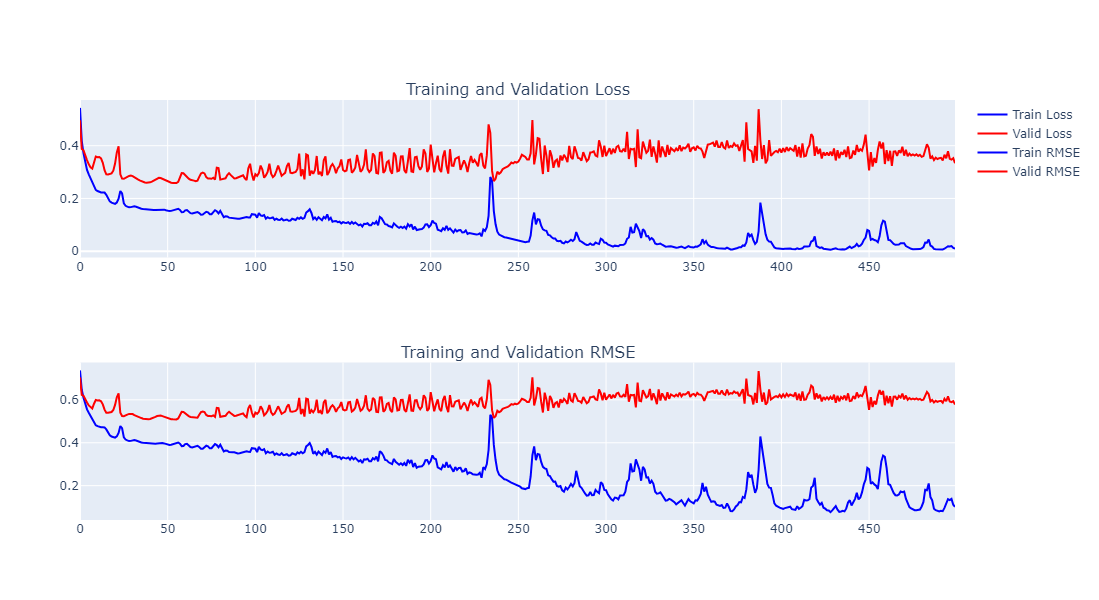

In [38]:
""" Üstteki kod bölümü için yapılan açıklamalar geçerli, sadece modelin yapısı farklı """

LSTM_input_size = len(features)
LSTM_hidden_size = 64
LSTM_output_size = 1
LSTM_num_layers = 2

LSTM_learning_rate = 0.001
LSTM_weight_decay = 0.0001

LSTM_seed = 123
torch.manual_seed(LSTM_seed)
LSTM_model = BiLSTMModel(input_size=LSTM_input_size, hidden_size=LSTM_hidden_size, output_size=LSTM_output_size, num_layers=LSTM_num_layers)

LSTM_criterion = CustomLoss(alpha=0.7)
LSTM_optimizer = optim.Adam(LSTM_model.parameters(), lr=LSTM_learning_rate, weight_decay=LSTM_weight_decay)

LSTM_n_epochs = 500

LSTM_stats_df = train_n_validate(train_loader, valid_loader, LSTM_model, LSTM_optimizer, LSTM_criterion, LSTM_n_epochs,
                    early_stopping=False, model_save_path=r"saved_LSTM")

best_loss_index = int(LSTM_stats_df.loc[LSTM_stats_df['Valid Loss'].idxmin()]['Epoch'])
best_epoch_loss = LSTM_stats_df.loc[best_loss_index]['Valid Loss']
best_rmse_index = int(LSTM_stats_df.loc[LSTM_stats_df['Valid RMSE'].idxmin()]['Epoch'])
best_epoch_rmse = LSTM_stats_df.loc[best_rmse_index]['Valid RMSE']

print(f"Best Epoch (Validation Loss): {best_loss_index}, Value: {best_epoch_loss}")
print(f"Best Epoch (Validation RMSE): {best_rmse_index}, Value: {best_epoch_rmse}")

fig = make_subplots(rows=2, cols=1, subplot_titles=['Training and Validation Loss', 'Training and Validation RMSE'])

fig.add_trace(go.Scatter(x=LSTM_stats_df['Epoch'], y=LSTM_stats_df['Train Loss'], mode='lines', name='Train Loss', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=LSTM_stats_df['Epoch'], y=LSTM_stats_df['Valid Loss'], mode='lines', name='Valid Loss', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=LSTM_stats_df['Epoch'], y=LSTM_stats_df['Train RMSE'], mode='lines', name='Train RMSE', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=LSTM_stats_df['Epoch'], y=LSTM_stats_df['Valid RMSE'], mode='lines', name='Valid RMSE', line=dict(color='red')), row=2, col=1)

fig.update_layout(
    height=600,
    showlegend=True,
)

# Show the figure
fig.show()

In [39]:
print("Best epoch was:", best_loss_index)
path = fr"saved_LSTM\model_epoch_{best_loss_index}.pth"
LSTM_model.load_state_dict(torch.load(path))

Best epoch was: 55


<All keys matched successfully>

In [40]:
torch.save(LSTM_model, fr"MODELS\main_LSTM_model.pth")

# PHASE 4: Testing

In [41]:
## Modelleri değerlendirme moduna almayı unutmayınız 
GRU_model.eval()
LSTM_model.eval()
print("")

## Plot inference

Bu bölümde eğitilmiş modellerin tahminlerini orjinal veriyle karşılaştıran grafikler hazırlanmıştır. 

In [42]:
## Grafiği çizilecek DataFrame'lerin oluşturulması
result_train_df = pd.DataFrame({'Time': train_df.index[:len(X_train)], desired_column: resampled_df[desired_column].iloc[:len(X_train)]})
result_valid_df = pd.DataFrame({'Time': valid_df.index[-len(X_valid):], desired_column: resampled_df[desired_column].iloc[-len(X_valid):]})

## Normalizasyon istatistikleri
mean = train_original_stats[desired_column]["mean"]
std = train_original_stats[desired_column]["std"]

#################################### GRU ######################################################
## GRU modelinin eğitim seti için yaptığı tahminleri toplama kısmı

train_predictions_GRU = []
for sequence, target in train_dataset:
    sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
    y_pred = GRU_model(sequence_tensor).item()
    train_predictions_GRU.append(y_pred)

train_predictions_GRU = np.array(train_predictions_GRU)

## Tahminlerin gerçek satış rakamlarına dönüştürülmesi
train_predictions_GRU_denorm = (train_predictions_GRU * std) + mean
result_train_df[f'{desired_column} GRU'] = train_predictions_GRU_denorm

## Aynı işlemin değerlendirme seti için olan kısmı
valid_predictions_GRU = []
for sequence, target in valid_dataset:
    sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
    y_pred = GRU_model(sequence_tensor).item()
    valid_predictions_GRU.append(y_pred)

valid_predictions_GRU = np.array(valid_predictions_GRU)

valid_predictions_GRU_denorm = (valid_predictions_GRU * std) + mean
result_valid_df[f'{desired_column} GRU'] = valid_predictions_GRU_denorm

#################################### LSTM ######################################################
## GRU için olan bölümün LSTM için olan versionu
train_predictions_LSTM = []
for sequence, target in train_dataset:
    sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
    y_pred = LSTM_model(sequence_tensor).item()
    train_predictions_LSTM.append(y_pred)

train_predictions_LSTM = np.array(train_predictions_LSTM)

train_predictions_LSTM_denorm = (train_predictions_LSTM * std) + mean
result_train_df[f'{desired_column} LSTM'] = train_predictions_LSTM_denorm

valid_predictions_LSTM = []
for sequence, target in valid_dataset:
    sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
    y_pred = LSTM_model(sequence_tensor).item()
    valid_predictions_LSTM.append(y_pred)

valid_predictions_LSTM = np.array(valid_predictions_LSTM)

valid_predictions_LSTM_denorm = (valid_predictions_LSTM * std) + mean
result_valid_df[f'{desired_column} LSTM'] = valid_predictions_LSTM_denorm

#################################### Ensemble ######################################################
# İki modelin tahminlerinin aritmetik ortalaması ile oluşturulan bir grup (ensemble) modeli
train_predictions_ensemble = (train_predictions_GRU_denorm + train_predictions_LSTM_denorm) / 2
valid_predictions_ensemble = (valid_predictions_GRU_denorm + valid_predictions_LSTM_denorm) / 2

result_train_df[f'{desired_column} Ensemble'] = train_predictions_ensemble
result_valid_df[f'{desired_column} Ensemble'] = valid_predictions_ensemble

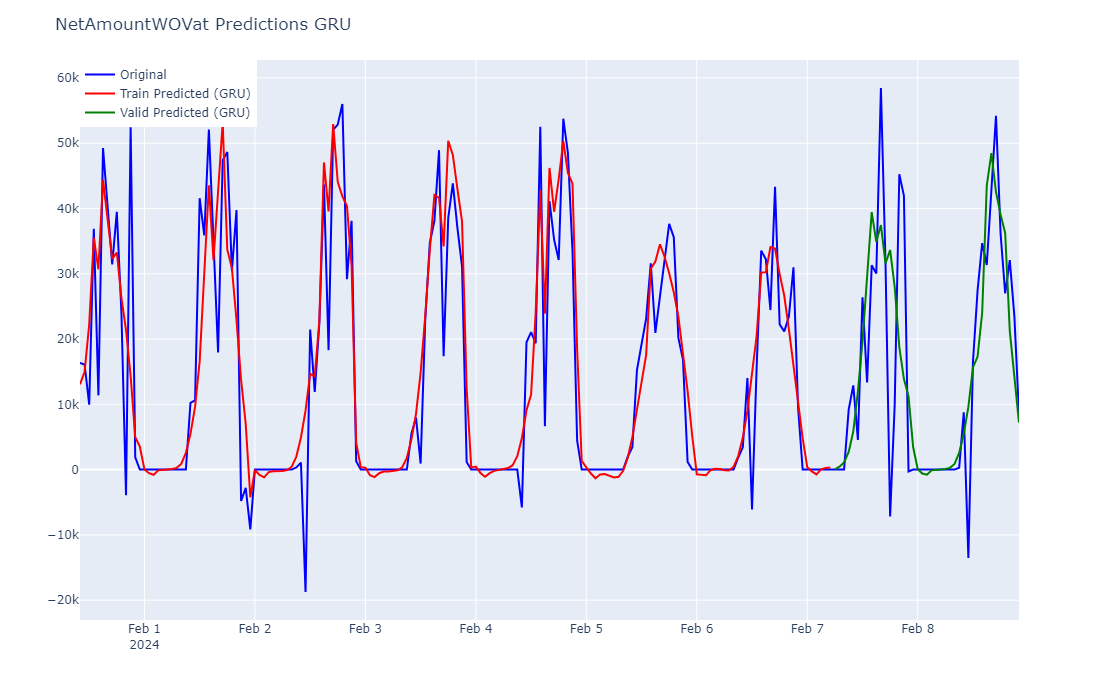

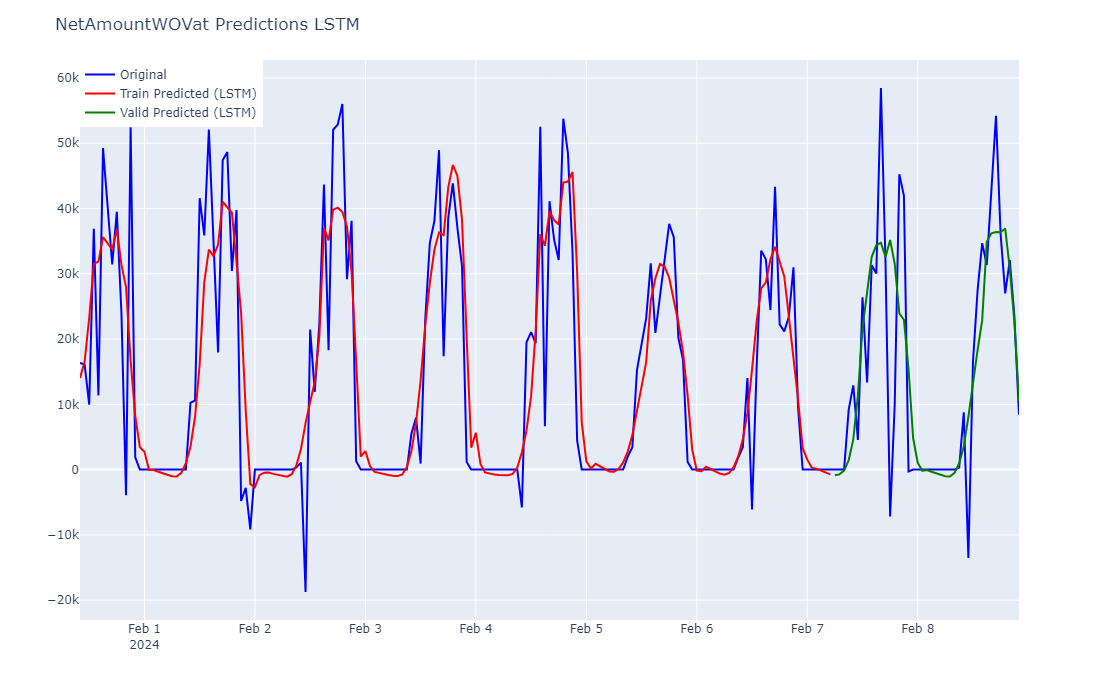

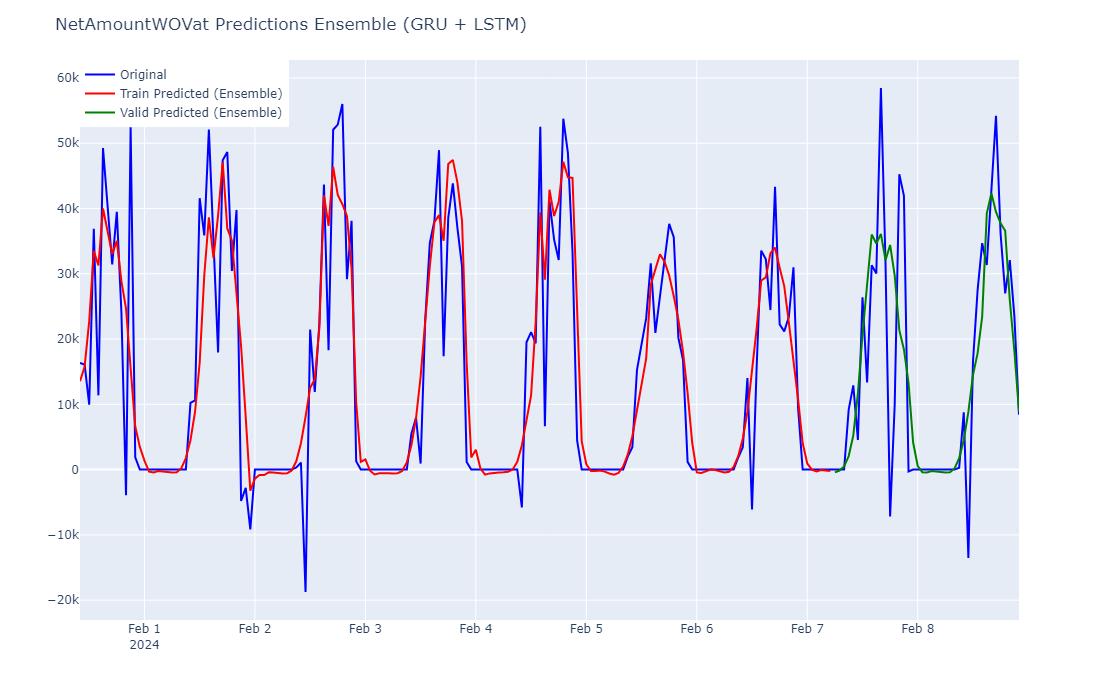

In [43]:
"""
İçeriklerini büyütüp küçülterek görebileceğiniz hareketli grafikler, boyularını değiştirmek için "fig.update_layout()" kısımlarını değiştirebilirsiniz.
"""

# GRU
fig = px.line()
fig.add_scatter(x=resampled_df.index, y=resampled_df[f'{desired_column}'], mode='lines', name='Original', line=dict(color='blue'))
fig.add_scatter(x=result_train_df['Time'], y=result_train_df[f'{desired_column} GRU'], mode='lines', name='Train Predicted (GRU)', line=dict(color='red'))
fig.add_scatter(x=result_valid_df['Time'], y=result_valid_df[f'{desired_column} GRU'], mode='lines', name='Valid Predicted (GRU)', line=dict(color='green'))
fig.update_layout(title=f'{desired_column} Predictions GRU', legend=dict(x=0, y=1), width=1100, height=700)
fig.show()

# LSTM
fig = px.line()
fig.add_scatter(x=resampled_df.index, y=resampled_df[f'{desired_column}'], mode='lines', name='Original', line=dict(color='blue'))
fig.add_scatter(x=result_train_df['Time'], y=result_train_df[f'{desired_column} LSTM'], mode='lines', name='Train Predicted (LSTM)', line=dict(color='red'))
fig.add_scatter(x=result_valid_df['Time'], y=result_valid_df[f'{desired_column} LSTM'], mode='lines', name='Valid Predicted (LSTM)', line=dict(color='green'))
fig.update_layout(title=f'{desired_column} Predictions LSTM', legend=dict(x=0, y=1), width=1100, height=700)
fig.show()

# Ensemble
fig = px.line()
fig.add_scatter(x=resampled_df.index, y=resampled_df[f'{desired_column}'], mode='lines', name='Original', line=dict(color='blue'))
fig.add_scatter(x=result_train_df['Time'], y=result_train_df[f'{desired_column} Ensemble'], mode='lines', name='Train Predicted (Ensemble)', line=dict(color='red'))
fig.add_scatter(x=result_valid_df['Time'], y=result_valid_df[f'{desired_column} Ensemble'], mode='lines', name='Valid Predicted (Ensemble)', line=dict(color='green'))
fig.update_layout(title=f'{desired_column} Predictions Ensemble (GRU + LSTM)', legend=dict(x=0, y=1), width=1100, height=700)
fig.show()

## Table Inference

Bu bölümde eğitilmiş modellerin tahminlerinin sayısal değerlerine odaklanılan grafikler hazılanmıştır.

In [44]:
result_df = pd.concat([result_train_df, result_valid_df], ignore_index=True)
result_df.head(30)

Time  NetAmountWOVat  NetAmountWOVat GRU  \
0  2024-01-31 10:00:00        16321.85        13063.384244   
1  2024-01-31 11:00:00        16112.86        14990.204958   
2  2024-01-31 12:00:00         9955.61        22256.568789   
3  2024-01-31 13:00:00        36883.48        35520.083726   
4  2024-01-31 14:00:00        11374.87        30685.253598   
5  2024-01-31 15:00:00        49252.87        44385.864888   
6  2024-01-31 17:00:00        31425.66        32283.569589   
7  2024-01-31 18:00:00        39486.80        33263.659008   
8  2024-01-31 19:00:00        24004.20        26286.084679   
9  2024-01-31 20:00:00        -3930.48        21357.927585   
10 2024-01-31 21:00:00        52459.47        14361.999742   
11 2024-01-31 22:00:00         1879.17         4948.769785   
12 2024-01-31 23:00:00            0.00         3512.576311   
13 2024-02-01 00:00:00            0.00           11.147111   
14 2024-02-01 01:00:00            0.00         -549.957488   
15 2024-02-01 02:00:00            0.00         -789.022927   
16 2024-02-01 03:00:00            0.00         -113.037605   
17 2024-02-01 04:00:00            0.00            3.135811   
18 2024-02-01 05:00:00            0.00           24.268592   
19 2024-02-01 06:00:00            0.00           99.167229   
20 2024-02-01 07:00:00            0.00          265.451667   
21 2024-02-01 08:00:00            0.00          874.550714   
22 2024-02-01 09:00:00            0.00         2561.162158   
23 2024-02-01 10:00:00        10213.80         5482.642237   
24 2024-02-01 11:00:00        10608.78         9601.345497   
25 2024-02-01 12:00:00        41577.63        16610.292368   
26 2024-02-01 13:00:00        35860.47        30810.495007   
27 2024-02-01 14:00:00        52076.60        43560.896602   
28 2024-02-01 15:00:00        35542.99        32093.137503   
29 2024-02-01 16:00:00        17930.29        43413.512497   

    NetAmountWOVat LSTM  NetAmountWOVat Ensemble  
0          14027.988878             13545.686561  
1          16517.724700             15753.964829  
2          23228.050526             22742.309657  
3          31504.789594             33512.436660  
4          31854.820466             31270.037032  
5          35618.209393             40002.037140  
6          33717.124522             33000.347055  
7          36827.022700             35045.340854  
8          31394.757536             28840.421108  
9          27948.600565             24653.264075  
10         16682.737970             15522.368856  
11          8245.622745              6597.196265  
12          3435.117799              3473.847055  
13          2725.058939              1368.103025  
14           -56.936181              -303.446835  
15           -73.271324              -431.147125  
16          -333.689598              -223.363602  
17          -566.307514              -281.585851  
18          -793.285840              -384.508624  
19         -1019.493440              -460.163105  
20         -1067.084984              -400.816659  
21          -504.140209               185.205252  
22           966.002424              1763.582291  
23          3513.799905              4498.221071  
24          8131.041277              8866.193387  
25         16129.103568             16369.697968  
26         28732.728868             29771.611938  
27         33695.756803             38628.326703  
28         32698.220270             32395.678886  
29         34475.402138             38944.457317

In [45]:
result_df.tail(30)

Time  NetAmountWOVat  NetAmountWOVat GRU  \
173 2024-02-07 17:00:00        31651.27        31598.884097   
174 2024-02-07 18:00:00        -7171.68        33646.649321   
175 2024-02-07 19:00:00        10000.07        27942.979048   
176 2024-02-07 20:00:00        45257.45        18771.705949   
177 2024-02-07 21:00:00        41939.75        13869.346290   
178 2024-02-07 22:00:00         -290.14        11228.097031   
179 2024-02-07 23:00:00            0.00         3460.311509   
180 2024-02-08 00:00:00            0.00           65.515730   
181 2024-02-08 01:00:00            0.00         -600.359791   
182 2024-02-08 02:00:00            0.00         -789.022927   
183 2024-02-08 03:00:00            0.00         -113.037605   
184 2024-02-08 04:00:00            0.00            3.135811   
185 2024-02-08 05:00:00            0.00           24.268592   
186 2024-02-08 06:00:00            0.00           99.167229   
187 2024-02-08 07:00:00            0.00          265.451667   
188 2024-02-08 08:00:00            0.00          874.550714   
189 2024-02-08 09:00:00          291.61         2561.162158   
190 2024-02-08 10:00:00         8764.06         5484.160302   
191 2024-02-08 11:00:00       -13541.08         9605.247232   
192 2024-02-08 12:00:00        16478.08        15650.177779   
193 2024-02-08 13:00:00        27416.69        17296.605421   
194 2024-02-08 14:00:00        34684.19        24024.151130   
195 2024-02-08 15:00:00        31353.18        43524.352488   
196 2024-02-08 16:00:00        43761.77        48477.164315   
197 2024-02-08 17:00:00        54206.70        42516.059806   
198 2024-02-08 18:00:00        36130.63        39079.943537   
199 2024-02-08 19:00:00        26992.63        36218.920813   
200 2024-02-08 20:00:00        32083.99        21217.905775   
201 2024-02-08 21:00:00        23429.17        13582.414105   
202 2024-02-08 22:00:00         8413.79         7209.840121   

     NetAmountWOVat LSTM  NetAmountWOVat Ensemble  
173         32561.379698             32080.131898  
174         35170.652425             34408.650873  
175         31509.350166             29726.164607  
176         23942.314893             21357.010421  
177         22951.892428             18410.619359  
178         15385.103521             13306.600276  
179          4839.013595              4149.662552  
180          1044.095589               554.805660  
181          -184.407912              -392.383851  
182           -73.271324              -431.147125  
183          -333.689598              -223.363602  
184          -566.307514              -281.585851  
185          -793.285840              -384.508624  
186         -1019.493440              -460.163105  
187         -1067.084984              -400.816659  
188          -504.140209               185.205252  
189           966.002424              1763.582291  
190          3533.449702              4508.805002  
191          8079.663076              8842.455154  
192         13338.472411             14494.325095  
193         18299.751512             17798.178466  
194         22857.808555             23440.979842  
195         34898.093885             39211.223186  
196         36204.871272             42341.017793  
197         36406.782394             39461.421100  
198         36372.762009             37726.352773  
199         36945.544439             36582.232626  
200         30751.488211             25984.696993  
201         22605.568483             18093.991294  
202         10582.128570              8895.984346

In [46]:
## Artış-Azalış tahmini için bir kısım
result_df["Original_Status"] = np.where(result_df[f"{desired_column}"].shift(-1) > result_df[f"{desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_GRU"] = np.where(result_df[f"{desired_column} GRU"].shift(-1) > result_df[f"{desired_column} GRU"], "Will Rise", "Will Fall")
result_df["Predicted_Status_LSTM"] = np.where(result_df[f"{desired_column} LSTM"].shift(-1) > result_df[f"{desired_column} LSTM"], "Will Rise", "Will Fall")

result_df.head(1000)

Time  NetAmountWOVat  NetAmountWOVat GRU  \
0   2024-01-31 10:00:00        16321.85        13063.384244   
1   2024-01-31 11:00:00        16112.86        14990.204958   
2   2024-01-31 12:00:00         9955.61        22256.568789   
3   2024-01-31 13:00:00        36883.48        35520.083726   
4   2024-01-31 14:00:00        11374.87        30685.253598   
5   2024-01-31 15:00:00        49252.87        44385.864888   
6   2024-01-31 17:00:00        31425.66        32283.569589   
7   2024-01-31 18:00:00        39486.80        33263.659008   
8   2024-01-31 19:00:00        24004.20        26286.084679   
9   2024-01-31 20:00:00        -3930.48        21357.927585   
10  2024-01-31 21:00:00        52459.47        14361.999742   
11  2024-01-31 22:00:00         1879.17         4948.769785   
12  2024-01-31 23:00:00            0.00         3512.576311   
13  2024-02-01 00:00:00            0.00           11.147111   
14  2024-02-01 01:00:00            0.00         -549.957488   
15  2024-02-01 02:00:00            0.00         -789.022927   
16  2024-02-01 03:00:00            0.00         -113.037605   
17  2024-02-01 04:00:00            0.00            3.135811   
18  2024-02-01 05:00:00            0.00           24.268592   
19  2024-02-01 06:00:00            0.00           99.167229   
20  2024-02-01 07:00:00            0.00          265.451667   
21  2024-02-01 08:00:00            0.00          874.550714   
22  2024-02-01 09:00:00            0.00         2561.162158   
23  2024-02-01 10:00:00        10213.80         5482.642237   
24  2024-02-01 11:00:00        10608.78         9601.345497   
25  2024-02-01 12:00:00        41577.63        16610.292368   
26  2024-02-01 13:00:00        35860.47        30810.495007   
27  2024-02-01 14:00:00        52076.60        43560.896602   
28  2024-02-01 15:00:00        35542.99        32093.137503   
29  2024-02-01 16:00:00        17930.29        43413.512497   
30  2024-02-01 17:00:00        47382.29        53171.345951   
31  2024-02-01 18:00:00        48652.41        33682.644891   
32  2024-02-01 19:00:00        30437.08        30869.734615   
33  2024-02-01 20:00:00        39773.96        22882.130547   
34  2024-02-01 21:00:00        -4807.72        13727.197276   
35  2024-02-01 22:00:00        -2797.72         7005.241557   
36  2024-02-01 23:00:00        -9165.83        -4231.956668   
37  2024-02-02 00:00:00            0.00          -68.186657   
38  2024-02-02 01:00:00            0.00         -812.257398   
39  2024-02-02 02:00:00            0.00        -1180.880311   
40  2024-02-02 03:00:00            0.00         -373.654674   
41  2024-02-02 04:00:00            0.00         -237.139402   
42  2024-02-02 05:00:00            0.00         -267.405021   
43  2024-02-02 06:00:00            0.00         -218.829074   
44  2024-02-02 07:00:00            0.00          -66.264625   
45  2024-02-02 08:00:00            0.00          444.290968   
46  2024-02-02 09:00:00          333.32         2001.180161   
47  2024-02-02 10:00:00         1078.03         4913.400896   
48  2024-02-02 11:00:00       -18747.92         9035.174835   
49  2024-02-02 12:00:00        21466.35        14657.862783   
50  2024-02-02 13:00:00        11907.53        14288.537976   
51  2024-02-02 14:00:00        22420.94        22862.522210   
52  2024-02-02 15:00:00        43681.18        47051.763133   
53  2024-02-02 16:00:00        18301.91        39551.861830   
54  2024-02-02 17:00:00        52060.01        52938.682324   
55  2024-02-02 18:00:00        52848.88        44052.913308   
56  2024-02-02 19:00:00        55993.66        41852.116948   
57  2024-02-02 20:00:00        29179.96        40380.070355   
58  2024-02-02 21:00:00        38099.98        31251.701191   
59  2024-02-02 22:00:00         1267.42         4127.358534   
60  2024-02-02 23:00:00            0.00          371.639661   
61  2024-02-03 00:00:00            0.00          304.600304   
62  2024-02-03 01:00:00            0.00         -8

Bu iki bölümde de modellerin tahmin ettiği toplam satış miktarları ile gerçek satış miktarlarının karşılaştırması gösterilmiştir

In [47]:
## Toplam satışlar
real_values = result_df[f'{desired_column}'].sum()
GRU_values = result_df[f'{desired_column} GRU'].sum()
LSTM_values = result_df[f'{desired_column} LSTM'].sum()
Ensemble_values = result_df[f'{desired_column} Ensemble'].sum()

print(f"Real {desired_column}:", real_values)
print(f"GRU {desired_column}:", GRU_values, f", LSTM {desired_column}:", LSTM_values, f", Ensemble {desired_column}:", Ensemble_values)

print("-------------------------------------------")

print("The prediction offness:")
print("GRU:", int(GRU_values - real_values), ", LSTM:", int(LSTM_values - real_values), ", Ensemble:", int(Ensemble_values - real_values))

Real NetAmountWOVat: 2832452.57
GRU NetAmountWOVat: 3015418.0509866937 , LSTM NetAmountWOVat: 2948372.1386582004 , Ensemble NetAmountWOVat: 2981895.094822447
-------------------------------------------
The prediction offness:
GRU: 182965 , LSTM: 115919 , Ensemble: 149442


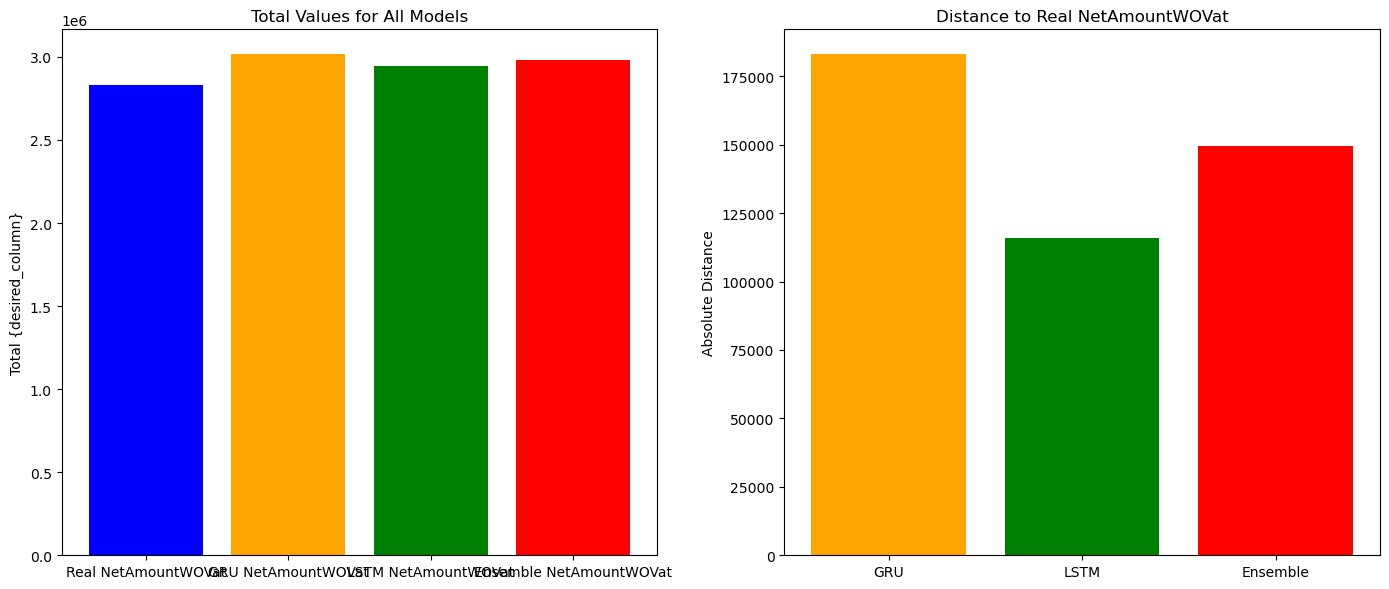

In [48]:
## Modellerin gerçek satışa yakınlıkları
distance_GRU = GRU_values - real_values
distance_LSTM = LSTM_values - real_values
distance_Ensemble = Ensemble_values - real_values

## Grafikler
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Toplam satışlar
axes[0].bar([f'Real {desired_column}', f'GRU {desired_column}', f'LSTM {desired_column}', f'Ensemble {desired_column}'],
            [real_values, GRU_values, LSTM_values, Ensemble_values],
            color=['blue', 'orange', 'green', 'red'])
axes[0].set_title('Total Values for All Models')
axes[0].set_ylabel('Total {desired_column}')


# Gerçek satışlara uzaklık
axes[1].bar(['GRU', 'LSTM', 'Ensemble'],
            [distance_GRU, distance_LSTM, distance_Ensemble],
            color=['orange', 'green', 'red'])
axes[1].set_title(f'Distance to Real {desired_column}')
axes[1].set_ylabel('Absolute Distance')

plt.tight_layout()
plt.show()

# PHASE 5: Forecasting

Bu bölümde eğitilmiş modeller kullanılarak gelecek tahmini yapılmıştır.

## Prepare the emtpy set

In [49]:
## Tahmin yapılacak aralıkları seçiniz
start_timestamp = '2024-02-08 21:00:00'
end_timestamp = '2024-02-18 23:00:00'

## Tahmin için DataFrame'i oluşturup değişkenleri hazırlama kısmı
forecast_timestamps = pd.date_range(start=start_timestamp, end=end_timestamp, freq='H')
forecast_df = pd.DataFrame(index=forecast_timestamps)

forecast_df[f'Forecasted {desired_column}'] = np.nan
forecast_df[f'{desired_column} Before'] = np.nan
forecast_df["HourInterval"] = forecast_df.index.hour
forecast_df['DayOfWeek'] = forecast_df.index.dayofweek + 1

forecast_df = forecast_df[[f'Forecasted {desired_column}', 'HourInterval', 'DayOfWeek', f'{desired_column} Before']]

forecast_df.head(4)

Forecasted NetAmountWOVat  HourInterval  DayOfWeek  \
2024-02-08 21:00:00                        NaN            21          4   
2024-02-08 22:00:00                        NaN            22          4   
2024-02-08 23:00:00                        NaN            23          4   
2024-02-09 00:00:00                        NaN             0          5   

                     NetAmountWOVat Before  
2024-02-08 21:00:00                    NaN  
2024-02-08 22:00:00                    NaN  
2024-02-08 23:00:00                    NaN  
2024-02-09 00:00:00                    NaN

In [50]:
## Daha önce seçilen sekans uzunluğuna göre son bilinen verilerin DataFrame'e eklendiği kısım
forecast_df.iloc[:sequence_length] = valid_df.iloc[-sequence_length:]
forecast_df.iloc[sequence_length, forecast_df.columns.get_loc(f'{desired_column} Before')] = forecast_df.iloc[sequence_length-1][f'Forecasted {desired_column}']

## Forecasts

In [51]:
GRU_forecast_df = forecast_df.copy()
LSTM_forecast_df = forecast_df.copy()

In [52]:
GRU_forecast_df

Forecasted NetAmountWOVat  HourInterval  DayOfWeek  \
2024-02-08 21:00:00                   1.039398            20          4   
2024-02-08 22:00:00                   0.554137            21          4   
2024-02-08 23:00:00                  -0.287751            22          4   
2024-02-09 00:00:00                        NaN             0          5   
2024-02-09 01:00:00                        NaN             1          5   
2024-02-09 02:00:00                        NaN             2          5   
2024-02-09 03:00:00                        NaN             3          5   
2024-02-09 04:00:00                        NaN             4          5   
2024-02-09 05:00:00                        NaN             5          5   
2024-02-09 06:00:00                        NaN             6          5   
2024-02-09 07:00:00                        NaN             7          5   
2024-02-09 08:00:00                        NaN             8          5   
2024-02-09 09:00:00                        NaN             9          5   
2024-02-09 10:00:00                        NaN            10          5   
2024-02-09 11:00:00                        NaN            11          5   
2024-02-09 12:00:00                        NaN            12          5   
2024-02-09 13:00:00                        NaN            13          5   
2024-02-09 14:00:00                        NaN            14          5   
2024-02-09 15:00:00                        NaN            15          5   
2024-02-09 16:00:00                        NaN            16          5   
2024-02-09 17:00:00                        NaN            17          5   
2024-02-09 18:00:00                        NaN            18          5   
2024-02-09 19:00:00                        NaN            19          5   
2024-02-09 20:00:00                        NaN            20          5   
2024-02-09 21:00:00                        NaN            21          5   
2024-02-09 22:00:00                        NaN            22          5   
2024-02-09 23:00:00                        NaN            23          5   
2024-02-10 00:00:00                        NaN             0          6   
2024-02-10 01:00:00                        NaN             1          6   
2024-02-10 02:00:00                        NaN             2          6   
2024-02-10 03:00:00                        NaN             3          6   
2024-02-10 04:00:00                        NaN             4          6   
2024-02-10 05:00:00                        NaN             5          6   
2024-02-10 06:00:00                        NaN             6          6   
2024-02-10 07:00:00                        NaN             7          6   
2024-02-10 08:00:00                        NaN             8          6   
2024-02-10 09:00:00                        NaN             9          6   
2024-02-10 10:00:00                        NaN            10          6   
2024-02-10 11:00:00                        NaN            11          6   
2024-02-10 12:00:00                        NaN            12          6   
2024-02-10 13:00:00                        NaN            13          6   
2024-02-10 14:00:00                        NaN            14          6   
2024-02-10 15:00:00                        NaN            15          6   
2024-02-10 16:00:00                        NaN            16          6   
2024-02-10 17:00:00                        NaN            17          6   
2024-02-10 18:00:00                        NaN            18          6   
2024-02-10 19:00:00                        NaN            19          6   
2024-02-10 20:00:00                        NaN            20          6   
2024-02-10 21:00:00                        NaN            21          6   
2024-02-10 22:00:00                        NaN            22          6   
2024-02-10 23:00:00                        NaN            23          6   
2024-02-11 00:00:00                        NaN             0          7   
2024-02-11 01:00:00                        NaN

In [53]:
############################## GRU ###########################################
"""
Bu bölümde, eğitilmiş GRU modeli ile adım adım öngörüler oluşturuluyor. Değişkenlerden biri "önceki istenilen" formunda olduğu için her zaman noktasını
tek tek tahmin edip geleceğe aktararak devam edilmesi gerekli.
"""
for i in range(1, len(forecast_df) + 100):
    ## Sekansı tanımlayıp ve PyTorch kütüphanesi için uyumlu hale getirme kısmı
    sequence = GRU_forecast_df.iloc[i:i + sequence_length]
    sequence = sequence[features].values

    torch_input = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)

    # Tahmin
    predicted_value = GRU_model(torch_input)
    
    # Tahmini geleceğe yazma
    GRU_forecast_df.iloc[i-1+sequence_length, GRU_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()
        
    # Eğer bütün tahminler yazıldıysa işlemi durdur
    if GRU_forecast_df.isnull().sum()[0] == 0:
        break

    # Tahmini bir sonraki zaman noktasındaki değişken yerine yazmak 
    GRU_forecast_df.iloc[i+sequence_length, GRU_forecast_df.columns.get_loc(f'{desired_column} Before')] = GRU_forecast_df.iloc[i-1+sequence_length, GRU_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

############################## LSTM ###########################################
""" 
Yukarıdaki açıklamaların aynıları aşağı için de geçerlidir. Tek fark modelin GRU değil LSTM olması.
"""

for i in range(1, len(forecast_df) + 100):
    sequence = LSTM_forecast_df.iloc[i:i + sequence_length]
    sequence = sequence[features].values
    
    torch_input = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)

    predicted_value = LSTM_model(torch_input)
    
    LSTM_forecast_df.iloc[i-1+sequence_length, LSTM_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()
        
    if LSTM_forecast_df.isnull().sum()[0] == 0:
        break

    LSTM_forecast_df.iloc[i+sequence_length, LSTM_forecast_df.columns.get_loc(f'{desired_column} Before')] = LSTM_forecast_df.iloc[i-1+sequence_length, LSTM_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

################################# Ensemble ###############################################
GRU_forecast_df_denorm = GRU_forecast_df.copy()
LSTM_forecast_df_denorm = LSTM_forecast_df.copy()

GRU_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before']] = (GRU_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before']] * std) + mean
LSTM_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before']] = (LSTM_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before']] * std) + mean

ensemble_forecast_df_denorm = pd.DataFrame(index=GRU_forecast_df_denorm.index)

ensemble_forecast_df_denorm[f'Ensemble Forecasted {desired_column}'] = (GRU_forecast_df_denorm[f'Forecasted {desired_column}'] + LSTM_forecast_df_denorm[f'Forecasted {desired_column}']) / 2

## Plot Inference

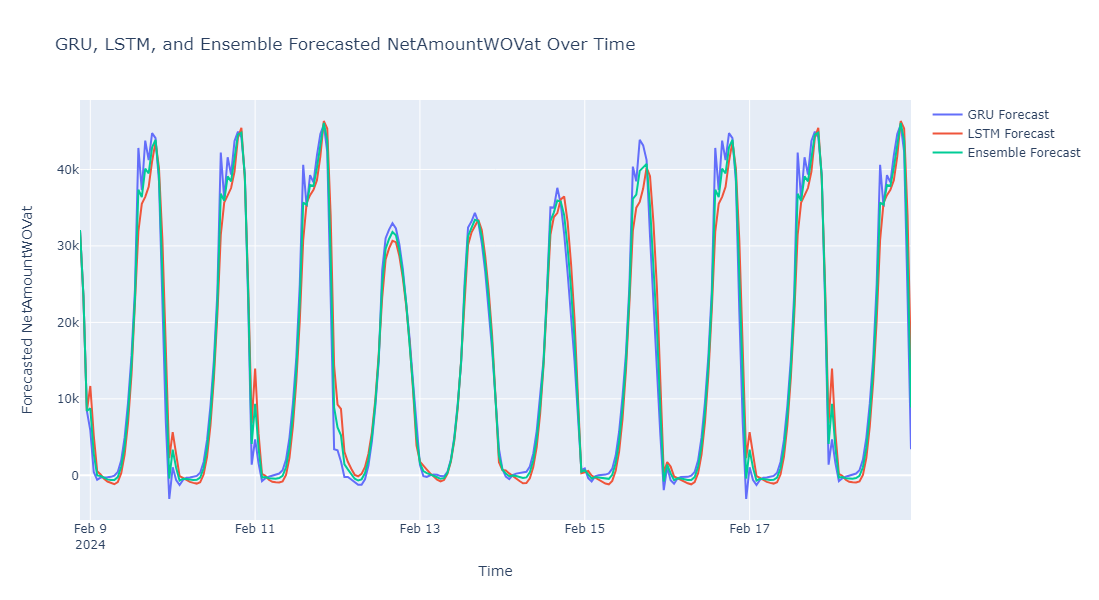

In [54]:
import plotly.graph_objects as go

fig = go.Figure()

# GRU
fig.add_trace(go.Scatter(x=GRU_forecast_df_denorm.index, y=GRU_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='GRU Forecast'))

# LSTM
fig.add_trace(go.Scatter(x=LSTM_forecast_df_denorm.index, y=LSTM_forecast_df_denorm[f'Forecasted {desired_column}'], mode='lines', name='LSTM Forecast'))

# Ensemble
fig.add_trace(go.Scatter(x=ensemble_forecast_df_denorm.index, y=ensemble_forecast_df_denorm[f'Ensemble Forecasted {desired_column}'], mode='lines', name='Ensemble Forecast'))

# Grafiğin görünüşünü değiştirmek için ayaralrın olduğu kısım
fig.update_layout(title=f'GRU, LSTM, and Ensemble Forecasted {desired_column} Over Time',
                  xaxis_title='Time',
                  yaxis_title=f'Forecasted {desired_column}',
                  width=1100,
                  height=600,
                  showlegend=True)

fig.show()

## Table Inference

Bu kısımda modelin öngörülerinin her bir gün için toplanmış hali gösterilmiştir

In [55]:
predictions_df = pd.concat([GRU_forecast_df_denorm[f'Forecasted {desired_column}'], LSTM_forecast_df_denorm[f'Forecasted {desired_column}'], ensemble_forecast_df_denorm[f'Ensemble Forecasted {desired_column}']], axis=1)
predictions_df.columns = [f'GRU Forecasted {desired_column}', f'LSTM Forecasted {desired_column}', f'Ensemble Forecasted {desired_column}']

predictions_df

GRU Forecasted NetAmountWOVat  \
2024-02-08 21:00:00                   32083.990000   
2024-02-08 22:00:00                   23429.170000   
2024-02-08 23:00:00                    8413.790000   
2024-02-09 00:00:00                    5871.869054   
2024-02-09 01:00:00                     446.556371   
2024-02-09 02:00:00                    -583.860935   
2024-02-09 03:00:00                    -295.945277   
2024-02-09 04:00:00                    -229.990252   
2024-02-09 05:00:00                    -254.825707   
2024-02-09 06:00:00                    -199.375945   
2024-02-09 07:00:00                     -45.417811   
2024-02-09 08:00:00                     436.108514   
2024-02-09 09:00:00                    1955.529784   
2024-02-09 10:00:00                    4958.588305   
2024-02-09 11:00:00                    9587.268582   
2024-02-09 12:00:00                   15649.994134   
2024-02-09 13:00:00                   24302.028212   
2024-02-09 14:00:00                   42814.635936   
2024-02-09 15:00:00                   37279.361359   
2024-02-09 16:00:00                   43780.658806   
2024-02-09 17:00:00                   41220.629634   
2024-02-09 18:00:00                   44750.923326   
2024-02-09 19:00:00                   44104.385059   
2024-02-09 20:00:00                   38431.053758   
2024-02-09 21:00:00                   21417.735405   
2024-02-09 22:00:00                    6861.211439   
2024-02-09 23:00:00                   -3095.020752   
2024-02-10 00:00:00                    1047.652623   
2024-02-10 01:00:00                    -631.335541   
2024-02-10 02:00:00                   -1259.664472   
2024-02-10 03:00:00                    -599.396649   
2024-02-10 04:00:00                    -323.786033   
2024-02-10 05:00:00                    -284.111175   
2024-02-10 06:00:00                    -228.059716   
2024-02-10 07:00:00                     -78.585613   
2024-02-10 08:00:00                     343.051567   
2024-02-10 09:00:00                    1743.070876   
2024-02-10 10:00:00                    4626.776337   
2024-02-10 11:00:00                    9119.607887   
2024-02-10 12:00:00                   15153.069364   
2024-02-10 13:00:00                   23885.537356   
2024-02-10 14:00:00                   42220.862115   
2024-02-10 15:00:00                   36135.973668   
2024-02-10 16:00:00                   41591.035317   
2024-02-10 17:00:00                   39318.360503   
2024-02-10 18:00:00                   43717.406106   
2024-02-10 19:00:00                   44941.032239   
2024-02-10 20:00:00                   44210.811182   
2024-02-10 21:00:00                   39364.055529   
2024-02-10 22:00:00                   22238.303110   
2024-02-10 23:00:00                    1392.918813   
2024-02-11 00:00:00                    4708.989963   
2024-02-11 01:00:00                    1583.714469   
2024-02-11 02:00:00                    -755.810476   
2024-02-11 03:00:00                    -392.434879   
2024-02-11 04:00:00                    -185.938733   
2024-02-11 05:00:00                     -61.061958   
2024-02-11 06:00:00                      54.130244   
2024-02-11 07:00:00                     230.462825   
2024-02-11 08:00:00                     658.411456   
2024-02-11 09:00:00                    2046.717852   
2024-02-11 10:00:00                    4936.508861   
2024-02-11 11:00:00                    9404.559173   
2024-02-11 12:00:00                   15434.653241   
2024-02-11 13:00:00                   24934.397875   
2024-02-11 14:00:00                   40605.772997   
2024-02-11 15:00:00                   35117.148083   
2024-02-11 16:00:00                   39266.397613   
2024-02-11 17:00:00                   38319.308030   
2024-02-11 18:00:00                   41847.567006   
2024-02-11 19:00:00                   44640.253426   
2024-02-11 20:00:00                   45855.438779   
2024-02-11 21:00:00                   42288.426629   
2024-02-11 22:00:00      

In [56]:
predictions_by_day = predictions_df.groupby(pd.Grouper(freq='D')).sum()  

In [57]:
predictions_by_day

GRU Forecasted NetAmountWOVat  LSTM Forecasted NetAmountWOVat  \
2024-02-08                   63926.950000                    63926.950000   
2024-02-09                  379164.100999                   374368.550200   
2024-02-10                  407644.585391                   386871.154561   
2024-02-11                  417297.444745                   417357.732275   
2024-02-12                  301155.430305                   310224.923298   
2024-02-13                  299889.788434                   298932.828640   
2024-02-14                  306556.769683                   312002.323295   
2024-02-15                  337721.566462                   332978.618240   
2024-02-16                  372650.646277                   358866.694440   
2024-02-17                  407644.585391                   386871.160940   
2024-02-18                  417297.444745                   417357.732275   

            Ensemble Forecasted NetAmountWOVat  
2024-02-08                        63926.950000  
2024-02-09                       376766.325600  
2024-02-10                       397257.869976  
2024-02-11                       417327.588510  
2024-02-12                       305690.176802  
2024-02-13                       299411.308537  
2024-02-14                       309279.546489  
2024-02-15                       335350.092351  
2024-02-16                       365758.670359  
2024-02-17                       397257.873165  
2024-02-18                       417327.588510

# PHASE 6: Explainable AI

Bu kısım şimdiye kadar eğitilen ve kullanılan modellerin tahminlerini ve tahminleri yaparken hangi değişkene ne kadar önem verdiklerini görebilmek için yapılmış bir bölümdür

## Torch Visualization

Bu kısımda modellerin iç yapısını ve ne tür işlemler yaptıklarını göstermek için kullanılan bir kütüphaneden model mimarisinin çıktısı alınmıştır.
Açıkçası bu kısmı incelemek model hakkında size pek bir kavrayış katmayacaktır çünkü oldukça karışık ve YZ mühendislerine odaklı bir kütüphane.

In [58]:
from torchviz import make_dot

dummy_input = Variable(torch.randn(1, sequence_length, len(features)), requires_grad=True)

# Gösterim parametreler yazılarak daha büyük ya da küçük hale getirilebilir (e.g., width=8, height=4)
graph_GRU = make_dot(GRU_model(dummy_input), params=dict(GRU_model.named_parameters()), show_attrs=True, show_saved=True)

# Gösterimi kaydetmek için olan kısım 
graph_GRU.render("RNN Model Graphs\main_GRU_model_graph", format="png", cleanup=True)

'RNN Model Graphs\\main_GRU_model_graph.png'

In [59]:
from torchviz import make_dot

dummy_input = Variable(torch.randn(1, sequence_length, len(features)), requires_grad=True)  # Adjust the input size accordingly

# Gösterim parametreler yazılarak daha büyük ya da küçük hale getirilebilir (e.g., width=8, height=4)
graph_LSTM = make_dot(LSTM_model(dummy_input), params=dict(LSTM_model.named_parameters()), show_attrs=True, show_saved=True)

# Gösterimi kaydetmek için olan kısım 
graph_LSTM.render("RNN Model Graphs\main_LSTM_model_graph", format="png", cleanup=True)

'RNN Model Graphs\\main_LSTM_model_graph.png'

## SHAP

In [60]:
""" 
SHAP yöntemi modelin yaptığı tahminlerin hangi değişkenlere bağlı olduğunu açıkça gösterebilen ve her model ailesi ile çalışabilen güçlü bir 
Açıklanabilir YZ kütüphanesi. Modelin tahminlerini çok net bir şekilde gösterebildiği için onu seçtim. 
Basitçe açıklamak gerekirse bu yöntem modelin değişkenlerinin her kombinasyonunu ayrı deneyerek hangi değişkenin hangi değerinin ne tür bir etki
yaptığını açıklamaya çalışır.
"""

import shap

In [61]:
## GRU ##

# PyTorch ile uyumlu olması için küçür bir arka kapı fonksiyonu kullanılması gerekiyor
def f_gru(f_input):
    padded_data = np.concatenate([f_input[:1]] * (sequence_length - 1) + [f_input], axis=0)
    
    X_sequences = []
    for i in range(len(padded_data) - sequence_length + 1):
        seq = padded_data[i:i+sequence_length]
        X_sequences.append(torch.tensor(seq, dtype=torch.float32))
        
    seq_tensor = torch.stack(X_sequences)
    with torch.no_grad():
        output = GRU_model(seq_tensor).numpy().flatten()
        return output
        
## Açıklayıcının kurulması
explainer_gru = shap.KernelExplainer(f_gru, valid_df[features])

## SHAP değerlerinin hesaplanması
shap_values_gru_valid = explainer_gru.shap_values(valid_df[features])
shap_values_gru_train = explainer_gru.shap_values(train_df[features])

df_shap_gru_valid = pd.DataFrame(shap_values_gru_valid, columns=features)
df_shap_gru_train = pd.DataFrame(shap_values_gru_train, columns=features)

## LSTM ##
# Üst bölümle aynı, sadece model farklı
def f_lstm(f_input):
    padded_data = np.concatenate([f_input[:1]] * (sequence_length - 1) + [f_input], axis=0)
    
    X_sequences = []
    for i in range(len(padded_data) - sequence_length + 1):
        seq = padded_data[i:i+sequence_length]
        X_sequences.append(torch.tensor(seq, dtype=torch.float32))
        
    seq_tensor = torch.stack(X_sequences)
    with torch.no_grad():
        output = LSTM_model(seq_tensor).numpy().flatten()
        return output

explainer_lstm = shap.KernelExplainer(f_lstm, valid_df[features])

shap_values_lstm_valid = explainer_lstm.shap_values(valid_df[features])
shap_values_lstm_train = explainer_lstm.shap_values(train_df[features])

df_shap_lstm_valid = pd.DataFrame(shap_values_lstm_valid, columns=features)
df_shap_lstm_train = pd.DataFrame(shap_values_lstm_train, columns=features)


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

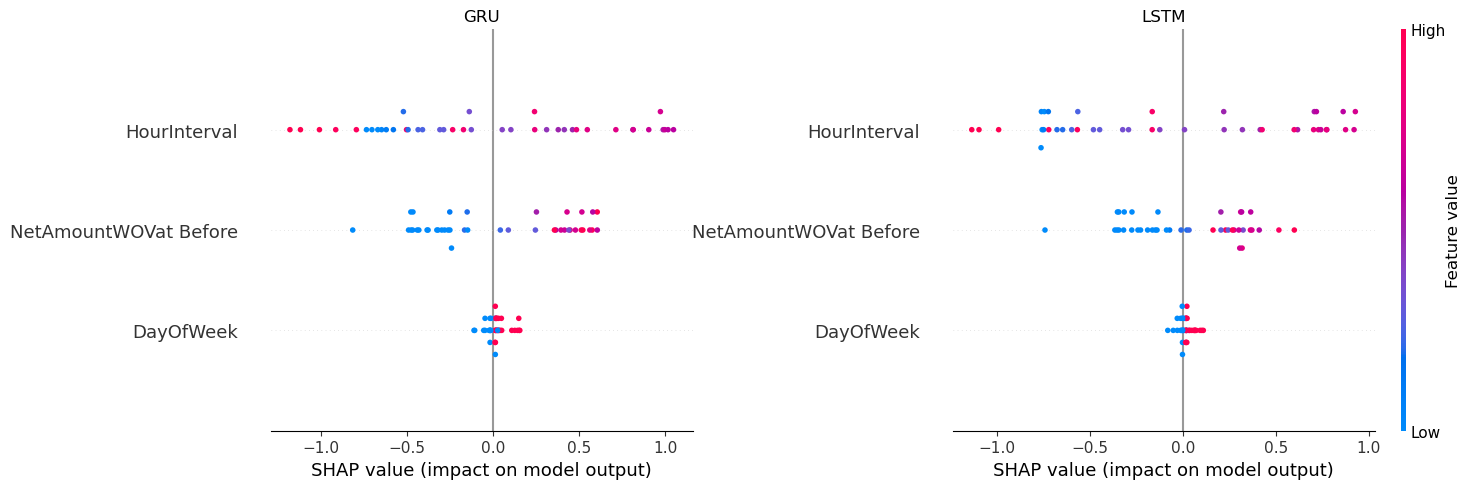

In [62]:
"""
Burada SHAP yönteminin bulduğu bulgularn veri setinin tamamına yayılmış açıklaması bulunmakta. Her nokta deneme setinde bulunan açıklanmış bir veriye 
karşılık geliyor. Y yönünde değişkenlerin ismini, X yönünde model tahmini üzerinde yaptıkları etkiyi görebilirsiniz. Noktaların rengi ise o değişkene ait
bir verinin değerinin yüksekliğini gösteriyor. Örneğin HourInterval için mavi olan noktalar (saat 1, 2 veya 3 gibi) modelin tahmini üzerinde güçlü bir
negatif etki yapmış, ki o saatlerde gerçekte hiç satış olmadığı düşünüldüğünde bu modelin doğru bir özelliği öğrendiğini gösterir.
"""

plt.figure(figsize=(15, 5))

# GRU
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_gru_valid, valid_original[features], plot_size=None, show=False)
plt.title('GRU')

# LSTM
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values_lstm_valid, valid_original[features], plot_size=None, show=False)
plt.title('LSTM')
print()

In [63]:
"""
Bu kısımda ise SHAP yöntemini tek bir veri üzerinde yaptığı açıklamalar görülebilir.
"""

j = 8 # Açıklama yapılacak doğrulama seti elamanının index'ini seçiniz 
sample = valid_df[features].iloc[[j]]
print("Features:", sample)
print("Label:", valid_df[f"{desired_column}"].iloc[[j]].values * std + mean)
print("")

denorm_pred_gru = int(sum(shap_values_gru_valid[j]) * std + mean)
denorm_pred_lstm = int(sum(shap_values_lstm_valid[j]) * std + mean)

# SHAP internet arayüzünde kuvvet grafiklerini oluşturmak için node.js altyapısı kullanıyor, bu nedenle aktifleştirilmesi lazım
shap.initjs()

print("GRU prediction")
print("Denormalized:", denorm_pred_gru)
display(shap.force_plot(explainer_gru.expected_value, shap_values_gru_valid[j], sample))

print("LSTM prediction")
print("Denormalized:", denorm_pred_lstm)
display(shap.force_plot(explainer_lstm.expected_value, shap_values_lstm_valid[j], sample))

print("Ensemble prediction")
print("Denorm amount:", int((denorm_pred_gru + denorm_pred_lstm) / 2))
ensemble_expected = (explainer_gru.expected_value + explainer_lstm.expected_value) / 2
ensemble_values = (shap_values_gru_valid[j] + shap_values_lstm_valid[j]) / 2
display(shap.force_plot(ensemble_expected, ensemble_values, sample))

Features:                      HourInterval  DayOfWeek  NetAmountWOVat Before
TransactionDateTime                                                
2024-02-07 14:00:00            14          3               -0.01199
Label: [31310.19]



GRU prediction
Denormalized: 35663


LSTM prediction
Denormalized: 33208


Ensemble prediction
Denorm amount: 34435
